# Create features based on event counts

The following feature sets are created:
- 'features_brand_bag': sparse one-hot encoded brand name
- 'features_brand_model_bag': sparse one-hot encoded device model (concatenated with brand model)
- 'features_brand_model.csv': couple of features derived from brand name and device model

In [1]:
import os
import math

import pandas as pd
import numpy as np

import seaborn as sns 
import matplotlib.pyplot as plt

%matplotlib inline

dir_in = './data_ori/'
dir_out = './data/'

## Load and preprocess data

In [2]:
def is_weekend(day_of_week):
    if day_of_week in []:
        return 1
    return 0

def is_during_day(hour_of_day):
    if hour_of_day>7 or hour_of_day>18:
        return 0
    

In [4]:
# Load app_events
print('Reading events...')
events = pd.read_csv(dir_in + 'events.csv')

events['timestamp'] = pd.to_datetime(events['timestamp'])
events['timestamp_h'] = events['timestamp'].dt.hour
events['timestamp_hq'] = ((events['timestamp_h'] - 1) // 6).clip_lower(0)
events['timestamp_d'] = events['timestamp'].dt.day
events.timestamp_d[events['timestamp_d']==30] = 0
events['timestamp_hd'] = (100*(events['timestamp_h']/24 + events['timestamp_d'])).astype(int)
events['timestamp_hqd'] = (100*(events['timestamp_hq']/4 + events['timestamp_d'])).astype(int)
events['timestamp_during_day'] = events['timestamp_hq'].isin([1,2]).astype(int)
events['timestamp_during_weekend'] = events['timestamp_d'].isin([30,1,7,8]).astype(int)

Reading events...


/Users/joostbloom/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
events.sample(10)

,event_id,device_id,timestamp,longitude,latitude,timestamp_h,timestamp_hq,timestamp_d,timestamp_hd,timestamp_hqd,timestamp_during_day,timestamp_during_weekend
2540599,2540600,1721034145377648824,2016-05-06 22:07:38,123.36,41.78,22,3,6,691,675,0,0
2811042,2811043,1788949327167974641,2016-05-07 18:17:20,0.00,0.00,18,2,7,775,750,1,1
304662,304663,-4814793614000680392,2016-05-04 11:35:38,116.63,40.10,11,1,4,445,425,1,0
140246,140247,-4655542782908579249,2016-05-07 09:06:06,0.00,0.00,9,1,7,737,725,1,1
2494089,2494090,2782390718038667752,2016-05-06 01:38:04,118.06,36.94,1,0,6,604,600,0,0
1688920,1688921,-4011352440630811162,2016-05-07 21:13:26,109.21,23.74,21,3,7,787,775,0,1
507026,507027,7217577211316396510,2016-05-05 16:24:07,0.00,0.00,16,2,5,566,550,1,0
2913515,2913516,8654897643856066919,2016-05-07 15:09:37,0.00,0.00,15,2,7,762,750,1,1
3028644,3028645,9085286543845925004,2016-05-07 14:06:25,114.87,30.38,14,2,7,758,750,1,1
2686942,2686943,749232266312627002,2016-05-04 23:08:20,0.00,0.00,23,3,4,495,475,0,0


## Total number of events

In [6]:
n_events = events.groupby('device_id').size()
n_events.sort_values(ascending=False).head()

device_id
 1186608308763918427    33426
 3915082290673137129    14568
-1656894751624916732     6731
-6242501228649113250     4150
-8340098378141155823     3973
dtype: int64

(0, 500)

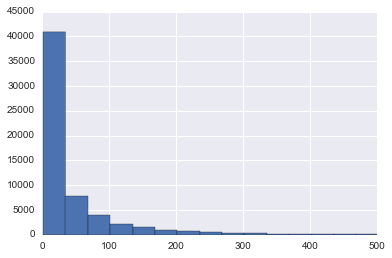

In [7]:
n_events.hist(bins=1000)
plt.xlim([0,500])

### Events per day

In [8]:
n_events_days = events.groupby(['device_id','timestamp_d']).size().unstack('timestamp_d')
n_events_days.head()

timestamp_d,0,1,2,3,4,5,6,7,8
device_id,,,,,,,,,
-9222956879900151005,NaN,NaN,NaN,NaN,NaN,NaN,30.0,35.0,NaN
-9222661944218806987,NaN,2.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN
-9222399302879214035,NaN,NaN,2.0,2.0,5.0,NaN,1.0,NaN,NaN
-9221825537663503111,NaN,29.0,17.0,NaN,4.0,32.0,12.0,5.0,NaN
-9221767098072603291,NaN,2.0,1.0,1.0,3.0,1.0,NaN,NaN,NaN


### Events per hour

In [9]:
n_events_hours = events.groupby(['device_id','timestamp_hd']).size().unstack('timestamp_hd')
n_events_hours.head()

timestamp_hd,95,100,104,108,112,116,120,125,129,133,...,762,766,770,775,779,783,787,791,795,800
device_id,,,,,,,,,,,,,,,,,,,,,
-9222956879900151005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
-9222661944218806987,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
-9222399302879214035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-9221825537663503111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-9221767098072603291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Events per hour (grouped per day)

In [10]:
n_events_hours_day = events.groupby(['device_id','timestamp_h']).size().unstack('timestamp_h')
n_events_hours_day.head()

timestamp_h,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
device_id,,,,,,,,,,,,,,,,,,,,,
-9222956879900151005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,5.0,22.0,NaN,NaN,NaN,NaN,4.0,6.0,NaN,3.0
-9222661944218806987,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,4.0,1.0,NaN,1.0,1.0,NaN
-9222399302879214035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,3.0
-9221825537663503111,NaN,NaN,NaN,NaN,NaN,NaN,5.0,17.0,13.0,4.0,...,3.0,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN
-9221767098072603291,NaN,NaN,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,...,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


### Events per quarter of day

In [11]:
n_events_quarter = events.groupby(['device_id','timestamp_hqd']).size().unstack('timestamp_hqd')
n_events_quarter.head()

timestamp_hqd,75,100,125,150,175,200,225,250,275,300,...,575,600,625,650,675,700,725,750,775,800
device_id,,,,,,,,,,,,,,,,,,,,,
-9222956879900151005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,20.0,10.0,NaN,22.0,10.0,3.0,NaN
-9222661944218806987,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
-9222399302879214035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
-9221825537663503111,NaN,NaN,29.0,NaN,NaN,NaN,15.0,2.0,NaN,NaN,...,6.0,5.0,7.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN
-9221767098072603291,NaN,NaN,NaN,2.0,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Events per quarter of day (grouped per day)

In [12]:
n_events_quarter_day = events.groupby(['device_id','timestamp_hq']).size().unstack('timestamp_hq')
n_events_quarter_day.head()

timestamp_hq,0,1,2,3
device_id,,,,
-9222956879900151005,NaN,22.0,30.0,13.0
-9222661944218806987,1.0,NaN,4.0,3.0
-9222399302879214035,NaN,2.0,4.0,4.0
-9221825537663503111,5.0,64.0,24.0,6.0
-9221767098072603291,2.0,2.0,4.0,NaN


### Events in weekend

In [13]:
n_event_during_weekend = events.groupby(['device_id','timestamp_during_weekend']).size().unstack('timestamp_during_weekend')
n_event_during_weekend.head()

timestamp_during_weekend,0,1
device_id,,
-9222956879900151005,30.0,35.0
-9222661944218806987,5.0,3.0
-9222399302879214035,10.0,NaN
-9221825537663503111,65.0,34.0
-9221767098072603291,6.0,2.0


### Events during day

In [14]:
n_events_during_day = events.groupby(['device_id','timestamp_during_day']).size().unstack('timestamp_during_day')
n_events_during_day.head()

timestamp_during_day,0,1
device_id,,
-9222956879900151005,13.0,52.0
-9222661944218806987,4.0,4.0
-9222399302879214035,4.0,6.0
-9221825537663503111,11.0,88.0
-9221767098072603291,2.0,6.0


## Create features

### Totals

In [15]:
feature_file = 'features_events_totals.csv'

df = pd.DataFrame(index=n_events.index)
df['n_events'] = n_events
df['r_hour_with_events'] = 1 - n_events_hours.isnull().sum(axis=1) / n_events_hours.shape[1]
df['r_day_with_events'] = 1 - n_events_days.isnull().sum(axis=1) / n_events_days.shape[1]
df['r_hour_grouped_with_events'] = 1 - n_events_hours_day.isnull().sum(axis=1) / n_events_hours_day.shape[1]
df['r_event_weekend'] = n_event_during_weekend[1] / n_event_during_weekend.sum(axis=1)
df['r_event_day'] = n_events_during_day[1] / n_events_during_day.sum(axis=1)
df.fillna(0, inplace=True)

In [16]:
print df.shape
df.head()

(60865, 6)


,n_events,r_hour_with_events,r_day_with_events,r_hour_grouped_with_events,r_event_weekend,r_event_day
device_id,,,,,,
-9222956879900151005,65,0.058824,0.222222,0.375000,0.538462,0.800000
-9222661944218806987,8,0.047059,0.777778,0.208333,0.375000,0.500000
-9222399302879214035,10,0.041176,0.444444,0.208333,0.000000,0.600000
-9221825537663503111,99,0.100000,0.666667,0.458333,0.343434,0.888889
-9221767098072603291,8,0.047059,0.555556,0.291667,0.250000,0.750000


In [17]:
df.to_csv(dir_out + feature_file)

### Per day

In [18]:
feature_file = 'features_events_per_day.csv'

df = pd.DataFrame(index=n_events.index)
df['n_event_day_max'] = n_events_days.max(axis=1).div(n_events)
df['n_event_day_min'] = n_events_days.min(axis=1).div(n_events)
df['n_event_day_std'] = n_events_days.std(axis=1).div(n_events)
df['n_event_day_avg'] = n_events_days.mean(axis=1).div(n_events)
df['n_event_day_med'] = n_events_days.median(axis=1).div(n_events)
df.fillna(0, inplace=True)

In [19]:
print df.shape
df.head()

(60865, 5)


,n_event_day_max,n_event_day_min,n_event_day_std,n_event_day_avg,n_event_day_med
device_id,,,,,
-9222956879900151005,0.538462,0.461538,0.054393,0.500000,0.500000
-9222661944218806987,0.250000,0.125000,0.047246,0.142857,0.125000
-9222399302879214035,0.500000,0.100000,0.173205,0.250000,0.200000
-9221825537663503111,0.323232,0.040404,0.119985,0.166667,0.146465
-9221767098072603291,0.375000,0.125000,0.111803,0.200000,0.125000


In [20]:
df.to_csv(dir_out + feature_file)

### Per hour

In [21]:
feature_file = 'features_events_per_hour.csv'

df = pd.DataFrame(index=n_events.index)
df['n_event_hour_max'] = n_events_hours.max(axis=1).div(n_events)
df['n_event_hour_min'] = n_events_hours.min(axis=1).div(n_events)
df['n_event_hour_std'] = n_events_hours.std(axis=1).div(n_events)
df['n_event_hour_avg'] = n_events_hours.mean(axis=1).div(n_events)
df['n_event_hour_med'] = n_events_hours.median(axis=1).div(n_events)
df.fillna(0, inplace=True)

In [22]:
print df.shape
df.head()

(60865, 5)


,n_event_hour_max,n_event_hour_min,n_event_hour_std,n_event_hour_avg,n_event_hour_med
device_id,,,,,
-9222956879900151005,0.307692,0.030769,0.088601,0.100000,0.069231
-9222661944218806987,0.125000,0.125000,0.000000,0.125000,0.125000
-9222399302879214035,0.200000,0.100000,0.053452,0.142857,0.100000
-9221825537663503111,0.191919,0.010101,0.049386,0.058824,0.040404
-9221767098072603291,0.125000,0.125000,0.000000,0.125000,0.125000


In [23]:
df.to_csv(dir_out + feature_file)

### Per hour (grouped)

In [24]:
feature_file = 'features_events_per_hour_grouped.csv'

df = pd.DataFrame(index=n_events.index)
df['n_event_hour_grouped_max'] = n_events_hours_day.max(axis=1).div(n_events)
df['n_event_hour_grouped_min'] = n_events_hours_day.min(axis=1).div(n_events)
df['n_event_hour_grouped_std'] = n_events_hours_day.std(axis=1).div(n_events)
df['n_event_hour_grouped_avg'] = n_events_hours_day.mean(axis=1).div(n_events)
df['n_event_hour_grouped_med'] = n_events_hours_day.median(axis=1).div(n_events)
df.fillna(0, inplace=True)

In [25]:
print df.shape
df.head()

(60865, 5)


,n_event_hour_grouped_max,n_event_hour_grouped_min,n_event_hour_grouped_std,n_event_hour_grouped_avg,n_event_hour_grouped_med
device_id,,,,,
-9222956879900151005,0.338462,0.030769,0.099042,0.111111,0.076923
-9222661944218806987,0.500000,0.125000,0.167705,0.200000,0.125000
-9222399302879214035,0.400000,0.100000,0.141421,0.200000,0.100000
-9221825537663503111,0.212121,0.020202,0.075589,0.090909,0.050505
-9221767098072603291,0.250000,0.125000,0.047246,0.142857,0.125000


In [26]:
df.to_csv(dir_out + feature_file)

### Per quarter

In [27]:
feature_file = 'features_events_per_quarter.csv'

df = pd.DataFrame(index=n_events.index)
df['n_event_quarter_max'] = n_events_quarter.max(axis=1).div(n_events)
df['n_event_quarter_min'] = n_events_quarter.min(axis=1).div(n_events)
df['n_event_quarter_std'] = n_events_quarter.std(axis=1).div(n_events)
df['n_event_quarter_avg'] = n_events_quarter.mean(axis=1).div(n_events)
df['n_event_quarter_med'] = n_events_quarter.median(axis=1).div(n_events)
df.fillna(0, inplace=True)


In [28]:
print df.shape
df.head()

(60865, 5)


,n_event_quarter_max,n_event_quarter_min,n_event_quarter_std,n_event_quarter_avg,n_event_quarter_med
device_id,,,,,
-9222956879900151005,0.338462,0.046154,0.121139,0.200000,0.153846
-9222661944218806987,0.125000,0.125000,0.000000,0.125000,0.125000
-9222399302879214035,0.200000,0.100000,0.051640,0.166667,0.200000
-9221825537663503111,0.292929,0.010101,0.086539,0.090909,0.060606
-9221767098072603291,0.250000,0.125000,0.064550,0.166667,0.125000


In [29]:
df.to_csv(dir_out + feature_file)

### Per quarter (grouped)

In [30]:
feature_file = 'features_events_per_quarter_grouped.csv'

df = pd.DataFrame(index=n_events.index)
df['n_event_quarter_grouped_max'] = n_events_quarter_day.max(axis=1).div(n_events)
df['n_event_quarter_grouped_min'] = n_events_quarter_day.min(axis=1).div(n_events)
df['n_event_quarter_grouped_std'] = n_events_quarter_day.std(axis=1).div(n_events)
df['n_event_quarter_grouped_avg'] = n_events_quarter_day.mean(axis=1).div(n_events)
df['n_event_quarter_grouped_med'] = n_events_quarter_day.median(axis=1).div(n_events)
df.fillna(0, inplace=True)

In [31]:
print df.shape
df.head()

(60865, 5)


,n_event_quarter_grouped_max,n_event_quarter_grouped_min,n_event_quarter_grouped_std,n_event_quarter_grouped_avg,n_event_quarter_grouped_med
device_id,,,,,
-9222956879900151005,0.461538,0.200000,0.130845,0.333333,0.338462
-9222661944218806987,0.500000,0.125000,0.190941,0.333333,0.375000
-9222399302879214035,0.400000,0.200000,0.115470,0.333333,0.400000
-9221825537663503111,0.646465,0.050505,0.278634,0.250000,0.151515
-9221767098072603291,0.500000,0.250000,0.144338,0.333333,0.250000


In [32]:
df.to_csv(dir_out + feature_file)